In [1]:
import wfdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from biosppy.signals import ecg

# Set the directory where your PhysioNet data is stored
data_path = "data/training2017"

# Read the reference file (contains labels)
labels_df = pd.read_csv(f'{data_path}/REFERENCE.csv', header=None, names=['record_name', 'label'])

# Given
data_path = "data/training2017"
frequency = 300

<Figure size 1500x1500 with 0 Axes>

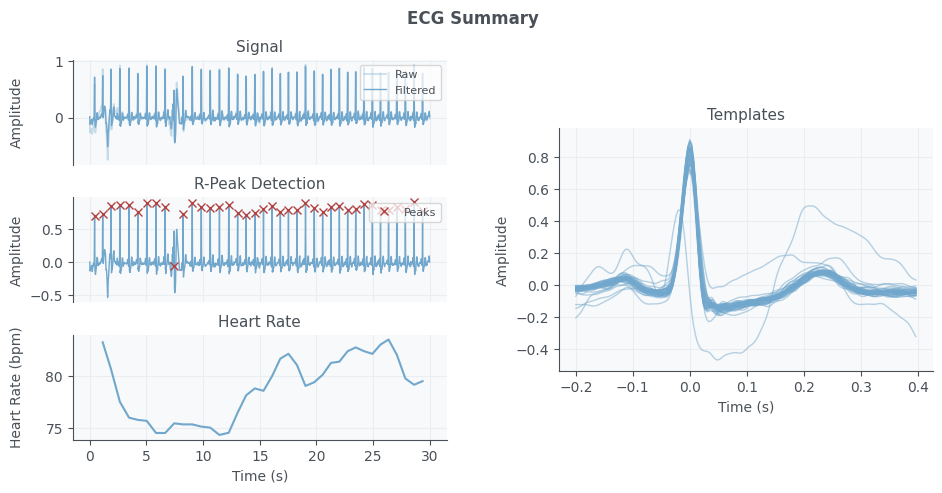

Available outputs: ['ts', 'filtered', 'rpeaks', 'templates_ts', 'templates', 'heart_rate_ts', 'heart_rate']


In [2]:
# Test the function with a single record

record_name = 'A00001'

plt.figure(figsize=(15, 15))

record = wfdb.rdrecord(f'{data_path}/{record_name}')
ecg_signal = record.p_signal[:, 0]

out = ecg.ecg(signal=ecg_signal, sampling_rate=frequency, show=True)
# Print all available keys
print("Available outputs:", out.keys())


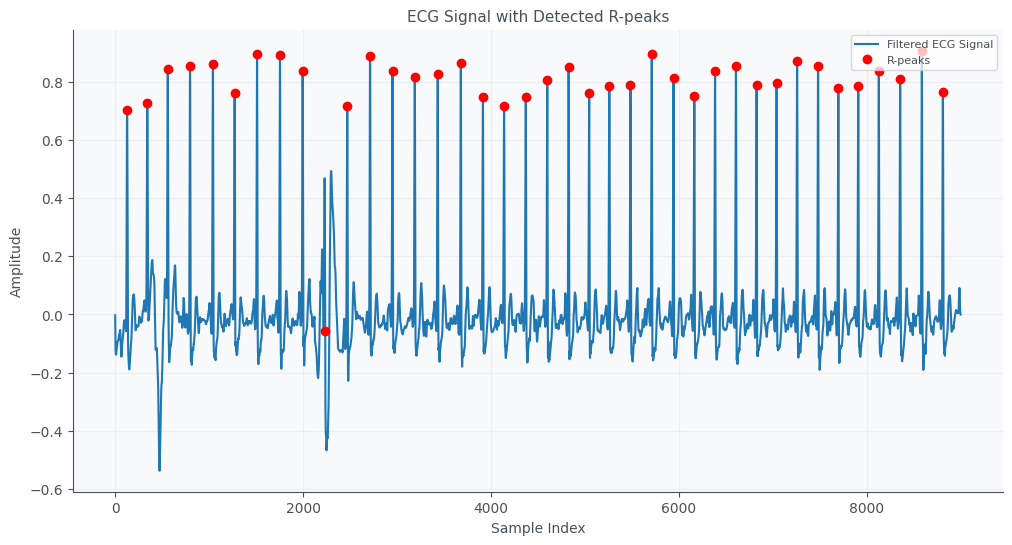

In [3]:
# Extract the processed signal and R-peak locations
filtered_ecg = out['filtered']
r_peaks = out['rpeaks']

# Plot the ECG signal with R-peaks
plt.figure(figsize=(12, 6))
plt.plot(filtered_ecg, label="Filtered ECG Signal")
plt.plot(r_peaks, filtered_ecg[r_peaks], "ro", label="R-peaks")  # Mark R-peaks with red dots
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.title("ECG Signal with Detected R-peaks")
plt.legend()
plt.show()

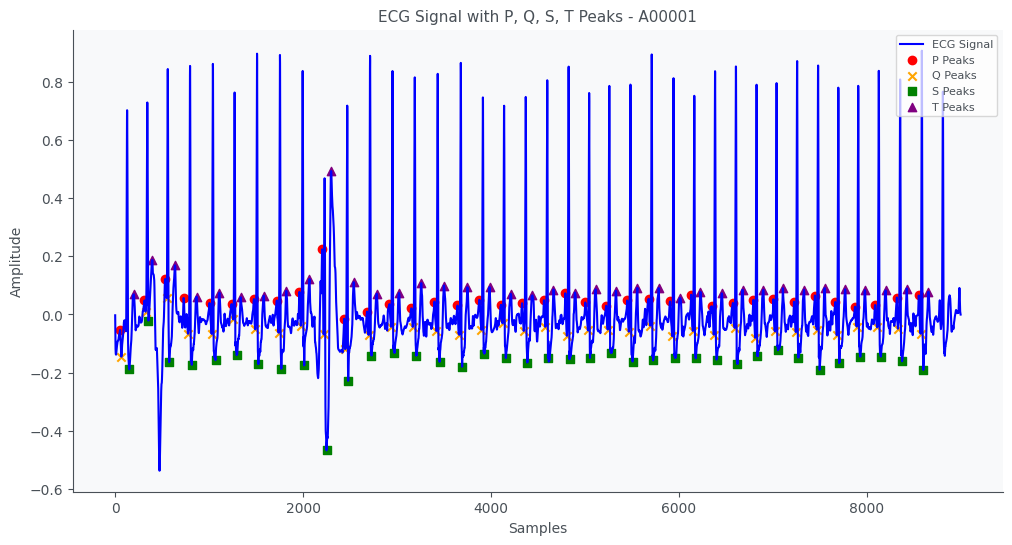

{'pq_interval': np.float64(0.06087719298245614), 'qrs_duration': np.float64(0.11403508771929824), 'st_interval': np.float64(0.17701754385964913), 'p_p_interval_mean': np.float64(0.7659459459459459), 'p_p_interval_std': np.float64(0.04720497209480748), 'qt_interval': np.float64(0.39710526315789474), 'total_beat_duration': np.float64(0.5203508771929825)}


In [8]:
import neurokit2 as nk

def compute_qrs(record_name, show=False):
    try: 
        record = wfdb.rdrecord(f'{data_path}/{record_name}')
        raw_ecg_signal = record.p_signal[:, 0]
        ecg_signal = nk.ecg_clean(raw_ecg_signal, sampling_rate=frequency, method="biosppy")
        _, waves = nk.ecg_delineate(ecg_signal, rpeaks=None, sampling_rate=frequency, method="peak")
        #print(waves.keys())

        def valid_peaks(peaks):
            """
            Filters out NaN values from the peaks array and ensures the result contains valid integer indices.

            Args:
                peaks (array-like): Array of peak indices, which may include NaN.

            Returns:
                np.ndarray: Array of valid integer indices.
            """
            if peaks is not None:
                # Convert to numpy array and filter out NaN values
                peaks = np.array(peaks)
                peaks = peaks[~np.isnan(peaks)]  # Remove NaN values
                return peaks.astype(int)  # Convert to integers
            return np.array([], dtype=int)  # Return empty array if peaks is None

        p_peaks = valid_peaks(waves['ECG_P_Peaks'])
        t_peaks = valid_peaks(waves['ECG_T_Peaks'])
        s_peaks = valid_peaks(waves['ECG_S_Peaks'])
        q_peaks = valid_peaks(waves['ECG_Q_Peaks'])
        p_onsets = valid_peaks(waves['ECG_P_Onsets'])
        t_offsets = valid_peaks(waves['ECG_T_Offsets'])


        if show:
            # Plot ECG with Peaks
            plt.figure(figsize=(12, 6))
            plt.plot(ecg_signal, label='ECG Signal', color='blue')

            # Plot the detected peaks
            if p_peaks is not None:
                plt.scatter(p_peaks, ecg_signal[p_peaks], color='red', label='P Peaks', marker='o')
            if q_peaks is not None:
                plt.scatter(q_peaks, ecg_signal[q_peaks], color='orange', label='Q Peaks', marker='x')
            if s_peaks is not None:
                plt.scatter(s_peaks, ecg_signal[s_peaks], color='green', label='S Peaks', marker='s')
            if t_peaks is not None:
                plt.scatter(t_peaks, ecg_signal[t_peaks], color='purple', label='T Peaks', marker='^')
          
            # Add labels and legend
            plt.title(f'ECG Signal with P, Q, S, T Peaks - {record_name}')
            plt.xlabel('Samples')
            plt.ylabel('Amplitude')
            plt.legend()
            plt.grid()
            plt.show()

        features = {}
        
        # 1. Intervals
        if len(p_peaks) > 0 and len(q_peaks) > 0:
            # Find the minimum length between p_peaks and q_peaks
            min_len = min(len(p_peaks), len(q_peaks))
            features['pq_interval'] = np.mean(np.abs(p_peaks[:min_len] - q_peaks[:min_len])) / frequency    

        if len(q_peaks) > 0 and len(s_peaks) > 0:
            min_len = min(len(q_peaks), len(s_peaks))
            features['qrs_duration'] = np.mean(np.abs(s_peaks[:min_len] - q_peaks[:min_len])) / frequency

        if len(s_peaks) > 0 and len(t_peaks) > 0:
            min_len = min(len(s_peaks), len(t_peaks))
            features['st_interval'] = np.mean(np.abs(t_peaks[:min_len] - s_peaks[:min_len])) / frequency
        
        # 2. Rhythm features
        if len(p_peaks) > 1:
            p_p_intervals = np.diff(p_peaks) / frequency
            features['p_p_interval_mean'] = np.mean(p_p_intervals)
            features['p_p_interval_std'] = np.std(p_p_intervals)
        
        # 3. Morphology features
        if len(p_onsets) > 0 and len(t_offsets) > 0:
            min_len = min(len(t_offsets), len(q_peaks))
            features['qt_interval'] = np.mean(np.abs(t_offsets[:min_len] - q_peaks[:min_len])) / frequency
            min_len = min(len(t_offsets), len(p_onsets))
            features['total_beat_duration'] = np.mean(np.abs(t_offsets[:min_len] - p_onsets[:min_len])) / frequency
        
        return features
    except:
        return {
            'pq_interval': np.nan,
            'qrs_duration': np.nan,
            'st_interval': np.nan,
            'p_p_interval_mean': np.nan,
            'p_p_interval_std': np.nan,
            'qt_interval': np.nan,
            'total_beat_duration': np.nan
        }


qrs_durations = compute_qrs(record_name, show=True)
print(qrs_durations)



In [12]:
from scipy.stats import kurtosis

# Create a reusable function for Pan-Tompkins algorithm
def compute_pan_tompkins(record_name):
    record = wfdb.rdrecord(f'{data_path}/{record_name}')
    ecg_signal = record.p_signal[:, 0]

    out = ecg.ecg(signal=ecg_signal, sampling_rate=frequency, show=False)

    filtered_ecg = out['filtered']
    r_peaks = out['rpeaks']
    heart_rate = out['heart_rate']

    # convert r_peaks to seconds
    r_peaks_seconds = r_peaks / frequency

    # Compute RR intervals
    rr_intervals = np.diff(r_peaks_seconds)

    # Compute mean and std of the RR intervals
    rr_mean = np.mean(rr_intervals)
    rr_std = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.square(np.diff(r_peaks_seconds))))
    rr_kurtosis = kurtosis(rr_intervals)

    # RR intervals falling in the lower 5% and higher 5% tails of their frequency distribution.
    lower_tail = np.percentile(rr_intervals, 5)
    upper_tail = np.percentile(rr_intervals, 95)


    # compute for second order rr intervals
    second_order_rr_intervals = np.diff(rr_intervals)
    second_order_rr_mean = np.mean(second_order_rr_intervals)
    second_order_rr_std = np.std(second_order_rr_intervals)

    # We computed the average power in very low frequency (VLF) = 0-0.04 Hz, low frequency (LF)= 0.04-0.15 Hz, high frequency (HF)= 0.15-0.5 Hz, and a ratio of LF to HF. Among these features, VLF provided the strongest discriminative power.  
    vlf_power = np.mean(filtered_ecg[0:int(0.04 * frequency)])
    lf_power = np.mean(filtered_ecg[int(0.04 * frequency):int(0.15 * frequency)])
    hf_power = np.mean(filtered_ecg[int(0.15 * frequency):int(0.5 * frequency)])
    lf_hf_ratio = lf_power / hf_power

    # Compute heart rate features
    if len(heart_rate) > 0:
        hr_mean = np.mean(heart_rate)
        hr_std = np.std(heart_rate)
        min_hr = np.min(heart_rate)
        max_hr = np.max(heart_rate)
    else:
        hr_mean = np.nan
        hr_std = np.nan
        min_hr = np.nan
        max_hr = np.nan

    # compute signal features
    signal_power = np.sum(np.square(filtered_ecg))
    signal_entropy = -np.sum(np.square(filtered_ecg) * np.log2(np.square(filtered_ecg)))
    signal_energy = np.sum(np.square(filtered_ecg))
    signal_power = signal_power / len(filtered_ecg)

    # compute pNN50
    pnn50 = np.sum(np.abs(np.diff(r_peaks_seconds)) <= 0.5) / (len(r_peaks_seconds)-1) * 100

    # irregularity features
    irregularity_mean = np.mean(np.diff(r_peaks_seconds))
    irregularity_std = np.std(np.diff(r_peaks_seconds))
    rr_coefficient = np.std(rr_intervals) / np.mean(rr_intervals)

    # add the qrs duation features
    qrs_features = compute_qrs(record_name)

    features = {
        'rr_mean': rr_mean,
        'rr_std': rr_std,
        'rmssd': rmssd,
        'rr_kurtosis': rr_kurtosis,
        'lower_tail': lower_tail,
        'upper_tail': upper_tail,
        'vlf_power': vlf_power,
        'lf_power': lf_power,
        'hf_power': hf_power,
        'lf_hf_ratio': lf_hf_ratio,
        'second_order_rr_intervals': second_order_rr_intervals,
        'second_order_rr_mean': second_order_rr_mean,
        'second_order_rr_std': second_order_rr_std,        
        'hr_mean': hr_mean,
        'hr_std': hr_std,
        'min_hr': min_hr,
        'max_hr': max_hr,
        'pnn50': pnn50,
        'signal_power': signal_power,
        'signal_energy': signal_energy,
        'signal_entropy': signal_entropy,
        'irregularity_mean': irregularity_mean,
        'irregularity_std': irregularity_std,
        'rr_coefficient': rr_coefficient,
        **qrs_features
    }

    return features

# Test the function with a single record
record_name = 'A00001'
features = compute_pan_tompkins(record_name)
print(features)


{'rr_mean': np.float64(0.7616666666666667), 'rr_std': np.float64(0.033093434977295604), 'rmssd': np.float64(0.7623852612358843), 'rr_kurtosis': np.float64(-1.1884996477150018), 'lower_tail': np.float64(0.7156666666666649), 'upper_tail': np.float64(0.8133333333333327), 'vlf_power': np.float64(-0.10708788558613758), 'lf_power': np.float64(-0.09472190319360935), 'hf_power': np.float64(-0.004058985172505567), 'lf_hf_ratio': np.float64(23.336351124224123), 'second_order_rr_intervals': array([ 0.01      ,  0.06333333,  0.02      , -0.04      ,  0.02666667,
        0.01666667, -0.00666667, -0.01      , -0.01333333,  0.02666667,
       -0.01333333, -0.00666667,  0.02333333,  0.00666667, -0.03666667,
       -0.03      ,  0.01333333, -0.00333333, -0.00333333, -0.03333333,
       -0.01      ,  0.03      ,  0.01      ,  0.01666667, -0.03666667,
        0.        ,  0.00333333, -0.00666667, -0.02333333,  0.02      ,
        0.01333333, -0.02666667, -0.01      ,  0.02333333,  0.02666667,
        0.0

In [10]:
from pyentrp import entropy as ent

def compute_sample_entropy(record_name):
    record = wfdb.rdrecord(f'{data_path}/{record_name}')
    ecg_signal = record.p_signal[:, 0]
    m = 2
    r = 0.2 * np.std(ecg_signal) 
    sample_entropy = ent.sample_entropy(ecg_signal, m, r)
    return {
        'record_name': record_name,
        'label': labels_df[labels_df.record_name == record_name].label.values[0],
        'sample_entropy': sample_entropy
    }

sample_entropy = compute_sample_entropy(record_name)
print(sample_entropy)


{'record_name': 'A00001', 'label': 'N', 'sample_entropy': array([1.36366274, 0.11149906])}


In [11]:
# run compute_sample_entropy for all records
all_sample_entropy = []
for i, record_name in enumerate(labels_df['record_name'][:200]):
    sample_entropy = compute_sample_entropy(record_name)
    all_sample_entropy.append(sample_entropy)
    if i % 10 == 0:
        print(f'Processed {i} records')

print(all_sample_entropy)


Processed 0 records
Processed 10 records
Processed 20 records
Processed 30 records


KeyboardInterrupt: 

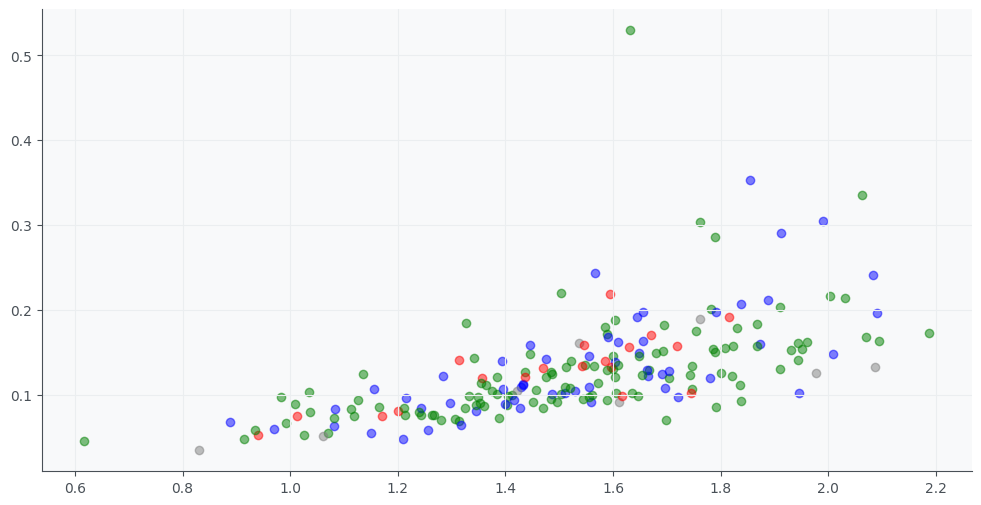

In [28]:
import seaborn as sns

# plot the sample entropy grouped by label
plt.figure(figsize=(12, 6))
color_map = {'N': 'green', 'A': 'red', 'O': 'blue', '~': 'gray'}
for sample_entropy in all_sample_entropy:
  plt.scatter(sample_entropy['sample_entropy'][0], sample_entropy['sample_entropy'][1], 
              color=color_map[sample_entropy['label']],
              alpha=0.5
              )
plt.show()

In [13]:
# Process all the records
all_features = []
for i, record_name in enumerate(labels_df['record_name']):
    features = compute_pan_tompkins(record_name)
    # include the record name and label
    features['record_name'] = record_name
    features['label'] = labels_df[labels_df.record_name == record_name].label.values[0]
    all_features.append(features)
    if i % 100 == 0:
        print(f'Processed {i} records')
        features_df = pd.DataFrame(all_features)
        features_df.to_csv('results/pan_tomkins_features.csv', index=False)
# Convert to DataFrame
features_df = pd.DataFrame(all_features)
features_df.to_csv('results/pan_tomkins_features.csv', index=False)

Processed 0 records
Processed 100 records
Processed 200 records
Processed 300 records
Processed 400 records
Processed 500 records
Processed 600 records
Processed 700 records
Processed 800 records
Processed 900 records
Processed 1000 records
Processed 1100 records
Processed 1200 records
Processed 1300 records
Processed 1400 records
Processed 1500 records
Processed 1600 records
Processed 1700 records
Processed 1800 records
Processed 1900 records
Processed 2000 records
Processed 2100 records
Processed 2200 records
Processed 2300 records
Processed 2400 records
Processed 2500 records
Processed 2600 records
Processed 2700 records
Processed 2800 records
Processed 2900 records
Processed 3000 records
Processed 3100 records
Processed 3200 records
Processed 3300 records
Processed 3400 records
Processed 3500 records
Processed 3600 records
Processed 3700 records
Processed 3800 records
Processed 3900 records
Processed 4000 records
Processed 4100 records
Processed 4200 records
Processed 4300 records


/opt/miniconda3/envs/afib/lib/python3.9/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Processed 5300 records
Processed 5400 records
Processed 5500 records
Processed 5600 records
Processed 5700 records
Processed 5800 records
Processed 5900 records
Processed 6000 records
Processed 6100 records
Processed 6200 records
Processed 6300 records
Processed 6400 records
Processed 6500 records
Processed 6600 records
Processed 6700 records
Processed 6800 records
Processed 6900 records
Processed 7000 records
Processed 7100 records
Processed 7200 records
Processed 7300 records
Processed 7400 records
Processed 7500 records
Processed 7600 records
Processed 7700 records
Processed 7800 records
Processed 7900 records
Processed 8000 records
Processed 8100 records
Processed 8200 records
Processed 8300 records
Processed 8400 records
Processed 8500 records
